In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import soundfile
import librosa

In [2]:
from datasets import load_dataset
from IPython.display import Audio
ds = load_dataset("JacobLinCool/VoiceBank-DEMAND-16k")

In [3]:
#get the waveform of audio
def wplot(arr,title="Waveform",xlab='Time (seconds)',ylab='Amplitude'):
    librosa.display.waveshow(arr, sr=16000)
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.show()


def equal_audio(wav):
    wav=wav[:90000]
    zero_padding=tf.zeros([90000]-tf.shape(wav),dtype=tf.float64)
    wav=tf.concat([zero_padding,wav],0)
    spec=tf.signal.stft(wav,frame_length=320,frame_step=32)
    spec=tf.abs(spec)
    spec=tf.expand_dims(spec,axis=2)
    return spec

#spectogram plot of audio
def spec_plot(spec,title="Spectogram",sr=16000):
    librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.show()

#check the data array is it consistent or not
def check_data(arr,k=1600):
    cnt=0
    for el in arr:
        if len(el)!=k:
            cnt+=1
        
    return cnt

In [4]:
data=ds['test'].select(range(600))

In [5]:
clean=[]
noisy=[]

for el in data:
    clean.append(np.array(el['clean']['array']))
    noisy.append(np.array(el['noisy']['array']))

In [6]:
import random

def get_audio(arr,idx= -1):
    l=len(arr)

    if idx== -1 or idx>=l:
        idx=random.randint(0,l)
    print(f"duration of audio {len(clean[idx])/16000}")
    wplot(arr[idx],f"Waveform {idx}")

duration of audio 5.1035


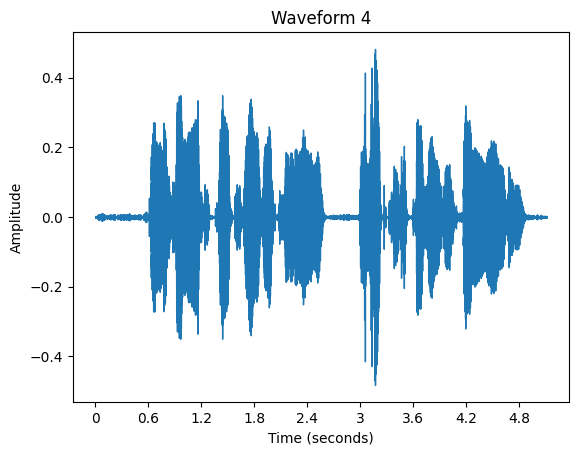

In [7]:
get_audio(clean,4)

duration of audio 5.1035


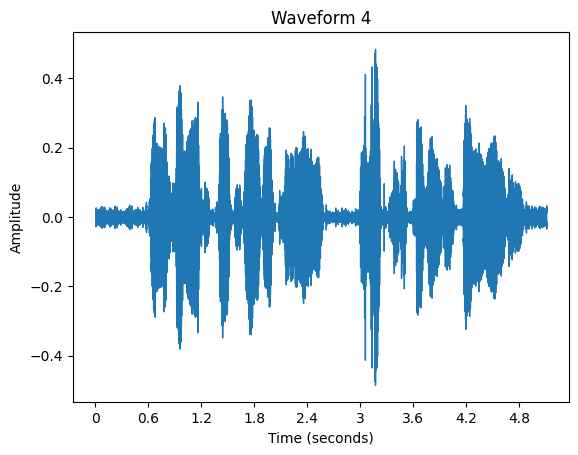

In [8]:
get_audio(noisy,4)

In [9]:
def break_audio(arr):
    brr=[]
    ans=[]

    i=0
    cnt=0
    while i<len(arr):
        cnt+=1
        brr.append(arr[i])
        if cnt==16000:
            ans.append(brr)
            cnt=0
        i+=1
        
    return ans
    

In [10]:
autoencoder=tf.keras.models.load_model('denoiser3.h5',compile=True)

In [11]:
cleanr=[]
noisyr=[]

In [12]:
def resize_audio(arr,r=16000):
    l=len(arr)
    i=0
    cnt=0
    br=[]
    brr=[]
    
    while i<l:
        br.append(arr[i])
        i+=1
        cnt+=1
        if cnt==r:
            brr.append(br)
            br=[]
            cnt=0

    if len(br)!=0:
        br.extend([0]*(r-len(br)))
        brr.append(br)
    
    return brr

In [13]:
for e in clean:
    cleanr.extend(resize_audio(e))

In [14]:
for e in noisy:
    noisyr.extend(resize_audio(e))

In [15]:
cleanr=np.array(cleanr)
noisyr=np.array(noisyr)

In [16]:
len(cleanr),len(noisyr)

(1825, 1825)

In [17]:
def get_spectrogram_features(cleanr,noisyr,sample_rate = 16000, duration_s = 1):
    '''
    Function to generate features for audio de-noising:
    - Reads from paths to audio files specified in "filepaths" list. 
    - Sets to a fixed length.
    - Generates spectrogram.
    - Adds noise and generates corresponding spectrogram.
    - Outputs clean and noisy spectrogram features.
    '''
    X_clean = []
    X_noisy = []
    
    # Get duration in samples:
    duration = int(sample_rate * duration_s)

    for data in cleanr:
        S=np.abs(librosa.stft(data, n_fft=2048))[:-1,:] 
        X_clean.append(S)

    
    
    for data in noisyr:
        S=np.abs(librosa.stft(data, n_fft=2048))[:-1,:] 
        X_noisy.append(S)
    
    X_clean = np.array(X_clean)
    X_clean = np.expand_dims(X_clean, -1)

    X_noisy = np.array(X_noisy)
    X_noisy = np.expand_dims(X_noisy, -1)
       
    return X_clean, X_noisy

In [18]:
sample_rate = 16000
X_clean, X_noisy = get_spectrogram_features(cleanr, noisyr,sample_rate = sample_rate)
spec_shape = (X_clean.shape[1], X_clean.shape[2])

In [19]:
autoencoder.evaluate(X_noisy,X_clean)

58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - loss: 23.6732


20.507633209228516

In [20]:
def specs(arr):
    S = np.abs(librosa.stft(arr, n_fft = 1024))
    data_inv = librosa.griffinlim(S)
    
    img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time')
    plt.show()

In [21]:
def sample_spec(idx= -1):
    l=X_clean.shape[0]

    if idx== -1 or idx>=l:
        idx=random.randint(0,l)
    print(f"the index plotting {idx}")
    arr=np.squeeze(X_clean[idx],axis= -1)
    brr=np.squeeze(X_noisy[idx],axis= -1)
    print("clean stft")
    spec_plot(arr)
    print(" noisy stft")
    spec_plot(brr)

the index plotting 11
clean stft


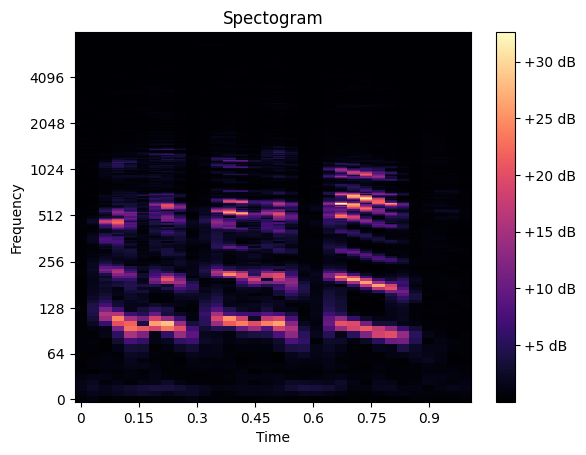

 noisy stft


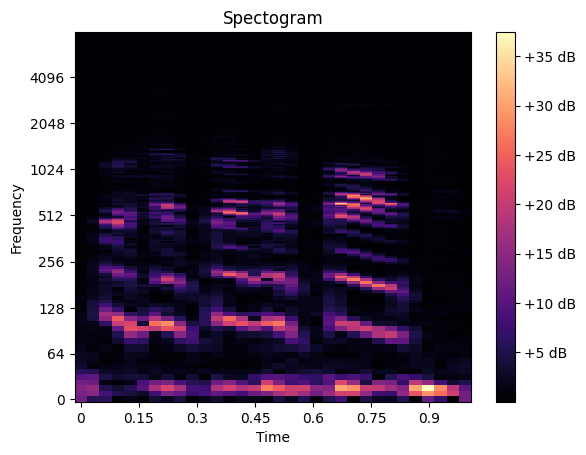

In [22]:
sample_spec(11)

## saving the testing data

In [23]:
# np.save('clean_test.npy',X_clean)
# np.save('noisy_test.npy',X_noisy)

In [24]:
y_pred=autoencoder.predict(X_noisy)

58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step


In [32]:
l=X_noisy.shape[0]
idx=2
print(f"the index is {idx}")
arr=np.squeeze(X_clean[idx],axis= -1)
brr=np.squeeze(X_noisy[idx],axis= -1)
crr=np.squeeze(y_pred[idx],axis= -1)

the index is 2


In [33]:
#clean audio
clean_inv = librosa.griffinlim(brr)
Audio(clean_inv,rate=16000)

In [34]:
#noisy audio
noisy_inv = librosa.griffinlim(arr)
Audio(noisy_inv,rate=16000)

In [35]:
#pred audio
pred_inv = librosa.griffinlim(crr)
Audio(pred_inv,rate=16000)

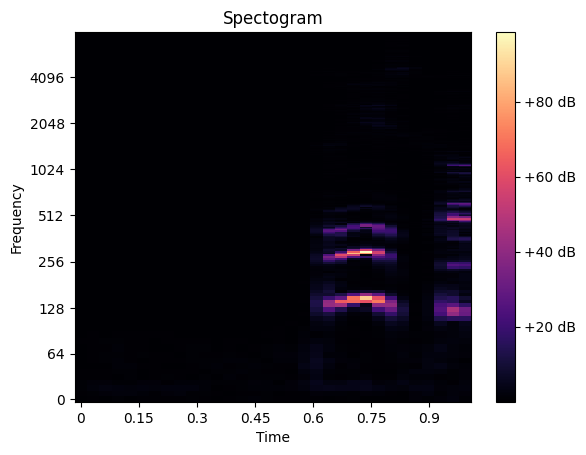

In [29]:
spec_plot(arr)

In [64]:
def convert(arr,sample_rate=16000,duration_s=1):
    brr=resize_audio(arr)
    brr=np.array(brr)
    
    audio = []
    
    # Get duration in samples:
    duration = int(sample_rate * duration_s)

    for data in brr:
        S=np.abs(librosa.stft(data, n_fft=2048))[:-1,:] 
        audio.append(S)
        
    audio = np.array(audio)
    audio = np.expand_dims(audio, -1)
    
    y_pred=autoencoder.predict(audio)

    res=[]
    for yp in y_pred:
        crr=np.squeeze(yp,axis= -1)
        aud=librosa.griffinlim(crr)
        res.extend(aud)

    return res

In [70]:
l=len(clean)
idx=random.randint(0,l)
print(f"the index is {idx}")

In [44]:
Audio(noisy[idx],rate=16000)

In [43]:
Audio(clean[idx],rate=16000)

In [68]:
pred=convert(noisy[idx])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


In [69]:
Audio(pred,rate=16000)